# Getting started (for datasets with unaligned features)

Import the required packages:

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt  # optional
import seaborn as sns  # optional

import scanpy as sc
from scipy import sparse

import networkx as nx
import torch

If you get trouble with installing CAME, you can download the source code from GitHub, 
and append the path to `sys.path`. For example:

```python
CAME_ROOT = Path('path/to/CAME')
sys.path.append(str(CAME_ROOT))
```

In [2]:
import came
from came import pipeline, pp, pl

ROOT = Path(".")  # set root

Using backend: pytorch


## 0 Load datasets

### 0.1 Load the example datasets

In [3]:
from came import load_example_data

example_data_dict = load_example_data()
print(example_data_dict.keys())

adatas = example_data_dict['adatas']
dsnames = example_data_dict['dataset_names']
df_varmap = example_data_dict['varmap']
df_varmap_1v1 = example_data_dict['varmap_1v1']

adata_raw1, adata_raw2 = adatas
key_class1 = key_class2 = example_data_dict['key_class']

# setting directory for results
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'
figdir = resdir / 'figs'
came.check_dirs(figdir)  # check and make the directory

dict_keys(['adatas', 'varmap', 'varmap_1v1', 'dataset_names', 'key_class'])
a new directory made:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs


### 0.2 Load your own datasets

To load your own datasets, see the code example below:

```python
# ========= customized paths ==========

dsnames = ('Baron_human', 'Baron_mouse')  # the dataset names, set by user
dsn1, dsn2 = dsnames

path_rawdata1 = CAME_ROOT / 'came/sample_data/raw-Baron_human.h5ad'
path_rawdata2 = CAME_ROOT / 'came/sample_data/raw-Baron_mouse.h5ad'
```
Path to homologous gene mappings, a dataframe with 2-columns, where 
the first column stores the reference genes and the second 
column stores the query ones.

Note that `path_varmap_1v1` is optional (can be `None`). If not provided, the 1-to-1 homologous mappings will be inferred from the whole mappings.

```python
path_varmap = CAME_ROOT / f'came/sample_data/gene_matches_human2mouse.csv'
path_varmap_1v1 = CAME_ROOT / f'came/sample_data/gene_matches_1v1_human2mouse.csv'

```

Load scRNA-seq datasets.

```python
# ========= load data =========
df_varmap = pd.read_csv(path_varmap)
df_varmap_1v1 = pd.read_csv(path_varmap_1v1) if path_varmap_1v1 else came.pp.take_1v1_matches(df_varmap)

adata_raw1 = sc.read_h5ad(path_rawdata1)
adata_raw2 = sc.read_h5ad(path_rawdata2)
adatas = [adata_raw1, adata_raw2]
```

Sepcifiy the column names of the cell-type labels, where `key_class1` is for reference data, and `key_class2` is for query data. If there aren't any cell-type or clustering labels for the query cells, you can set `key_class=None`.

```python
key_class1 = 'cell_ontology_class'  # set by user
key_class2 = 'cell_ontology_class'  # set by user
```

Setting directory for results

```python
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'  # set by user
figdir = resdir / 'figs'
came.check_dirs(figdir)  # check and make the directory
```

Filtering genes (a preprocessing step, optional)

```python
sc.pp.filter_genes(adata_raw1, min_cells=3)
sc.pp.filter_genes(adata_raw2, min_cells=3)
```

### 0.3 Inspect the compositions of different classes

In [4]:
# Inspect classes
if key_class2 is not None:
    group_counts_ori = pd.concat([
        pd.value_counts(adata_raw1.obs[key_class1]),
        pd.value_counts(adata_raw2.obs[key_class2]),
    ], axis=1, keys=dsnames)
else:
    group_counts_ori = pd.value_counts(adata_raw1.obs[key_class1])
    
group_counts_ori

,Baron_human,Baron_mouse
B cell,NaN,10.0
Schwann cell,13.0,6.0
T cell,7.0,7.0
endothelial cell,252.0,139.0
leukocyte,NaN,8.0
macrophage,55.0,36.0
mast cell,25.0,NaN
pancreatic A cell,2326.0,191.0
pancreatic D cell,601.0,218.0
pancreatic PP cell,255.0,41.0


## 1 The default pipeline of CAME

Parameter setting:

In [5]:
# the numer of training epochs 
# (a recommended setting is 200-400 for whole-graph training, and 80-200 for sub-graph training)
n_epochs = 300

# the training batch size
# When the GPU memory is limited, set 1024 or more if possible.
batch_size = None

# the number of epochs to skip for checkpoint backup
n_pass = 100

# whether to use the single-cell networks
use_scnets = True

# node genes, use both DEGs and HVGs by default
node_source = 'deg,hvg'
ntop_deg = 50

In [6]:
came_inputs, (adata1, adata2) = pipeline.preprocess_unaligned(
    adatas,
    key_class=key_class1,
    use_scnets=use_scnets,
    ntop_deg=ntop_deg,
    node_source=node_source,
)

outputs = pipeline.main_for_unaligned(
    **came_inputs,
    df_varmap=df_varmap,
    df_varmap_1v1=df_varmap_1v1,
    dataset_names=dsnames,
    key_class1=key_class1,
    key_class2=key_class2,
    do_normalize=True,
    n_epochs=n_epochs,
    resdir=resdir,
    n_pass=n_pass,
    batch_size=batch_size,
    plot_results=True,
)
dpair = outputs['dpair']
trainer = outputs['trainer']
h_dict = outputs['h_dict']
out_cell = outputs['out_cell']
predictor = outputs['predictor']


obs_ids1, obs_ids2 = dpair.obs_ids1, dpair.obs_ids2
obs = dpair.obs
classes = predictor.classes


[leiden] Time used:  0.2723 s
650 genes before taking unique
taking total of 501 unique differential expressed genes
400 genes before taking unique
taking total of 345 unique differential expressed genes
already exists:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs
already exists:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)
[*] Setting dataset names:
	0-->Baron_human
	1-->Baron_mouse
[*] Setting aligned features for observation nodes (self._features)
[*] Setting un-aligned features (`self._ov_adjs`) for making links connecting observation and variable nodes
[*] Setting adjacent matrix connecting variables from these 2 datasets (`self._vv_adj`)
Index(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name',
       'donor', 'latent_1', 'latent_10', 'latent_2', 'latent_3', 'latent_4',
       'latent_5', 'latent_6', 'latent_7', 'latent_8', 'latent_9', 'library',
       'organ', 'organism', 'platform', 'tSNE1', 'tSNE2'],
      dtype='object')
Index([

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch 0000 | Train Acc: 0.0533 | Test: 0.0323 (max=0.0323) | AMI=-0.0000 | Time: 0.4114
Epoch 0005 | Train Acc: 0.2948 | Test: 0.4740 (max=0.4804) | AMI=0.0435 | Time: 0.1553
Epoch 0010 | Train Acc: 0.5011 | Test: 0.4899 (max=0.4899) | AMI=0.4180 | Time: 0.1315
Epoch 0015 | Train Acc: 0.4372 | Test: 0.6193 (max=0.6193) | AMI=0.4547 | Time: 0.1239
Epoch 0020 | Train Acc: 0.7186 | Test: 0.7174 (max=0.7174) | AMI=0.5456 | Time: 0.1194
Epoch 0025 | Train Acc: 0.7508 | Test: 0.7216 (max=0.7301) | AMI=0.5801 | Time: 0.1166
Epoch 0030 | Train Acc: 0.8419 | Test: 0.7937 (max=0.7937) | AMI=0.6283 | Time: 0.1149
Epoch 0035 | Train Acc: 0.8615 | Test: 0.8165 (max=0.8165) | AMI=0.6809 | Time: 0.1134
Epoch 0040 | Train Acc: 0.8743 | Test: 0.7773 (max=0.8165) | AMI=0.6177 | Time: 0.1124
Epoch 0045 | Train Acc: 0.8766 | Test: 0.7927 (max=0.8340) | AMI=0.6383 | Time: 0.1117
Epoch 0050 | Train Acc: 0.9152 | Test: 0.8208 (max=0.8340) | AMI=0.6644 | Time: 0.1110
Epoch 0055 | Train Acc: 0.9121 | Test: 0.8

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


object saved into:
	 _temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\datapair_init.pickle
Re-order the rows
figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\contingency_matrix(acc94.5%).png
figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\contingency_matrix-train.png
figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\heatmap_probas.pdf


### Load other checkpoint (optional)

You can load other model checkpoint if the default model is not satisfying.

For example, load the last checkpoint and compute the results of it:

```python
outputs = pipeline.gather_came_results(
    dpair,
    trainer,
    classes=classes,
    keys=(key_class1, key_class2),
    keys_compare=(key_class1, key_class2),
    resdir=resdir,
    checkpoint='last',
    batch_size=None,
)
```

You can get all saved checkpoint numbers by:

In [7]:
came.get_checkpoint_list(resdir / '_models')

[100,
 101,
 104,
 106,
 107,
 109,
 123,
 129,
 152,
 167,
 172,
 178,
 215,
 235,
 249,
 258,
 275,
 299,
 99]

### Plot the contingency matrix for query dataset

figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\contingency_mat.png


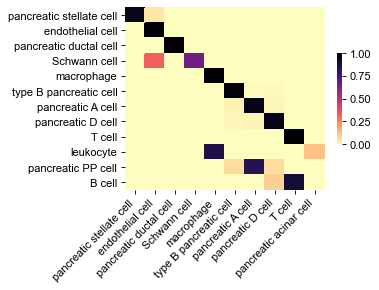

In [8]:
# contingency matrix for query dataset
y_true = obs['celltype'][obs_ids2].values
y_pred = obs['predicted'][obs_ids2].values

ax, contmat = pl.plot_contingency_mat(
    y_true, y_pred, norm_axis=1, 
    order_rows=False, order_cols=False,
)
pl._save_with_adjust(ax.figure, figdir / 'contingency_mat.png')
ax.figure

### Plot heatmap of predicted probabilities

figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\heatmap_probas.pdf


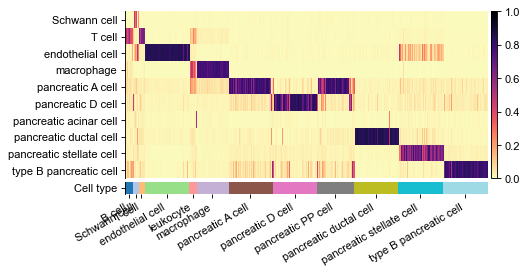

In [9]:
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]
df_probs = obs[list(classes)]


gs = pl.wrapper_heatmap_scores(
        df_probs.iloc[obs_ids2], obs.iloc[obs_ids2], ignore_index=True,
        col_label='celltype', col_pred='predicted',
        n_subsample=50,
        cmap_heat='magma_r',  # if prob_func == 'softmax' else 'RdBu_r'
        fp=figdir / f'heatmap_probas.pdf'
    )

gs.figure

## 2 Further analysis

By default, CAME will use the **last** layer of hidden states, as the embeddings, to produce cell- and gene-UMAP. 

> You can also load ALL of the model hidden states that have been seved during CAME's default pipeline:

```py
hidden_list = came.load_hidden_states(resdir / 'hidden_list.h5')
hidden_list  # a list of dicts
h_dict = hidden_list[-1]. # the last layer of hidden states
```

Make AnnData objects, storing only the CAME-embeddings and annotations, for cells and genes.

In [10]:
adt = pp.make_adata(h_dict['cell'], obs=dpair.obs, assparse=False, ignore_index=True)
gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False, ignore_index=True)

# adt.write(resdir / 'adt_hidden_cell.h5ad')
# gadt.write_h5ad(resdir / 'adt_hidden_gene.h5ad')

adding columns to `adata.obs` (ignore_index=True):
original_name, dataset, REF, celltype, predicted, max_probs, is_right, pancreatic acinar cell, type B pancreatic cell, pancreatic D cell, pancreatic stellate cell, pancreatic ductal cell, pancreatic A cell, pancreatic epsilon cell, pancreatic PP cell, endothelial cell, macrophage, Schwann cell, mast cell, T cell, done!
adding columns to `adata.obs` (ignore_index=True):
name, dataset, done!


### 2.1 UMAP of cell embeddings

... storing 'dataset' as categorical
... storing 'REF' as categorical
... storing 'celltype' as categorical
... storing 'predicted' as categorical


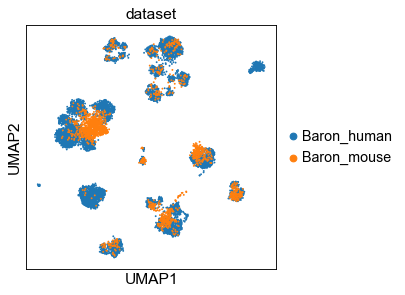

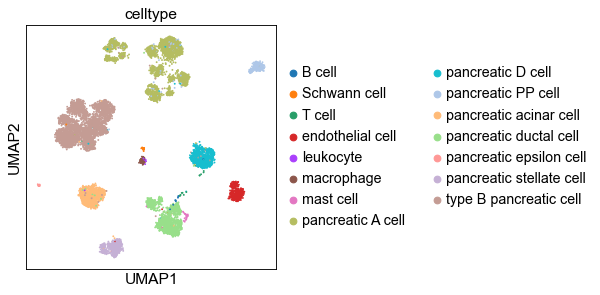

In [11]:
sc.set_figure_params(dpi_save=200)

sc.pp.neighbors(adt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(adt)
# sc.pl.umap(adt, color=['dataset', 'celltype'], ncols=1)

ftype = ['.svg', ''][1]
sc.pl.umap(adt, color='dataset', save=f'-dataset{ftype}')
sc.pl.umap(adt, color='celltype', save=f'-ctype{ftype}')

Store UMAP coordinates:

In [12]:
obs_umap = adt.obsm['X_umap']
obs['UMAP1'] = obs_umap[:, 0]
obs['UMAP2'] = obs_umap[:, 1]
obs.to_csv(resdir / 'obs.csv')
adt.write(resdir / 'adt_hidden_cell.h5ad')

Setting UMAP to the original adata

In [13]:
adata1.obsm['X_umap'] = obs_umap[obs_ids1]
adata2.obsm['X_umap'] = obs_umap[obs_ids2]

### 2.2 UMAP of genes

... storing 'name' as categorical
... storing 'dataset' as categorical


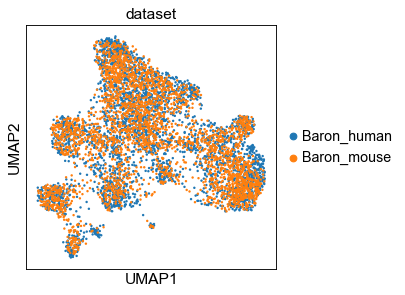

In [14]:
sc.pp.neighbors(gadt, n_neighbors=15, metric='cosine', use_rep='X')

# gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False, ignore_index=True)
sc.tl.umap(gadt)
sc.pl.umap(gadt, color='dataset', )

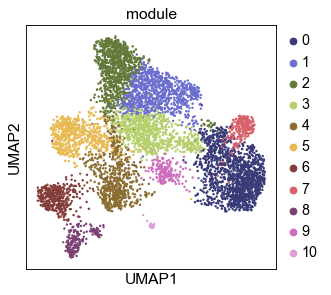

In [15]:
# joint gene module extraction 
sc.tl.leiden(gadt, resolution=.8, key_added='module')
sc.pl.umap(gadt, color='module', ncols=1, palette='tab20b')

# backup results is needed
# gadt.write(resdir / 'adt_hidden_gene.h5ad')

Visualize gene UMAPs:

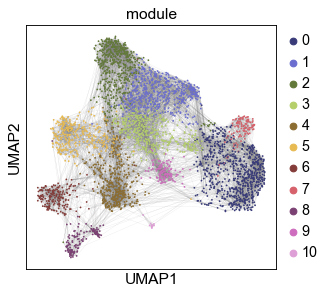

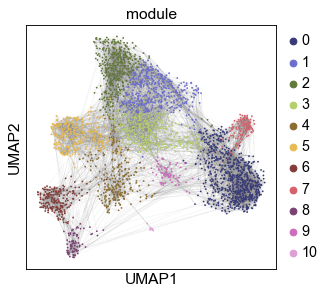

In [16]:
# gadt.obs_names = gadt.obs_names.astype(str)
gadt1, gadt2 = pp.bisplit_adata(gadt, 'dataset', dsnames[0], reset_index_by='name')

color_by = 'module'
palette = 'tab20b'
sc.pl.umap(gadt1, color=color_by, s=10, edges=True, edges_width=0.05,
           palette=palette,
           save=f'_{color_by}-{dsnames[0]}')
sc.pl.umap(gadt2, color=color_by, s=10, edges=True, edges_width=0.05,
           palette=palette,
           save=f'_{color_by}-{dsnames[0]}')

Compute the link-weights (embedding similarity) between homologous gene pairs:

In [17]:
df_var_links = came.weight_linked_vars(
    gadt.X, dpair._vv_adj, names=dpair.get_vnode_names(),
    matric='cosine', index_names=dsnames,
)

gadt1.write(resdir / 'adt_hidden_gene1.h5ad') 
gadt2.write(resdir / 'adt_hidden_gene2.h5ad')

### 2.3 Gene-expression-profiles (for each cell type) on gene UMAP

Compute average expressions for each cell type.

In [18]:
# averaged expressions
avg_expr1 = pp.group_mean_adata(
    adatas[0], groupby=key_class1,
    features=dpair.vnode_names1, use_raw=True)
avg_expr2 = pp.group_mean_adata(
    adatas[1], groupby=key_class2 if key_class2 else 'predicted',
    features=dpair.vnode_names2, use_raw=True)


Computing averages grouped by cell_ontology_class
Computing averages grouped by cell_ontology_class


plot cell type gene-profiles (plot all the cell types) on UMAP

In [19]:
plkwds = dict(cmap='RdYlBu_r', vmax=2.5, vmin=-1.5, do_zscore=True, 
              axscale=3, ncols=5, with_cbar=True)

fig1, axs1 = pl.adata_embed_with_values(
    gadt1, avg_expr1, 
    fp=figdir / f'umap_exprAvgs-{dsnames[0]}-all.png', 
    **plkwds)
fig2, axs2 = pl.adata_embed_with_values(
    gadt2, avg_expr2, 
    fp=figdir / f'umap_exprAvgs-{dsnames[1]}-all.png', 
    **plkwds)

figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\umap_exprAvgs-Baron_human-all.png
figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\umap_exprAvgs-Baron_mouse-all.png


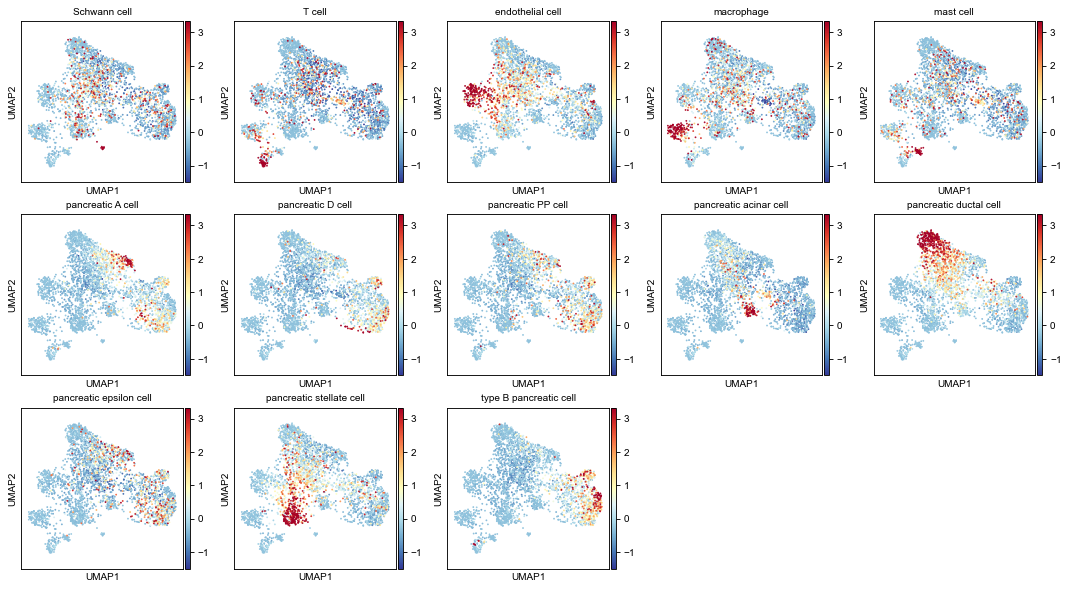

In [20]:
fig1

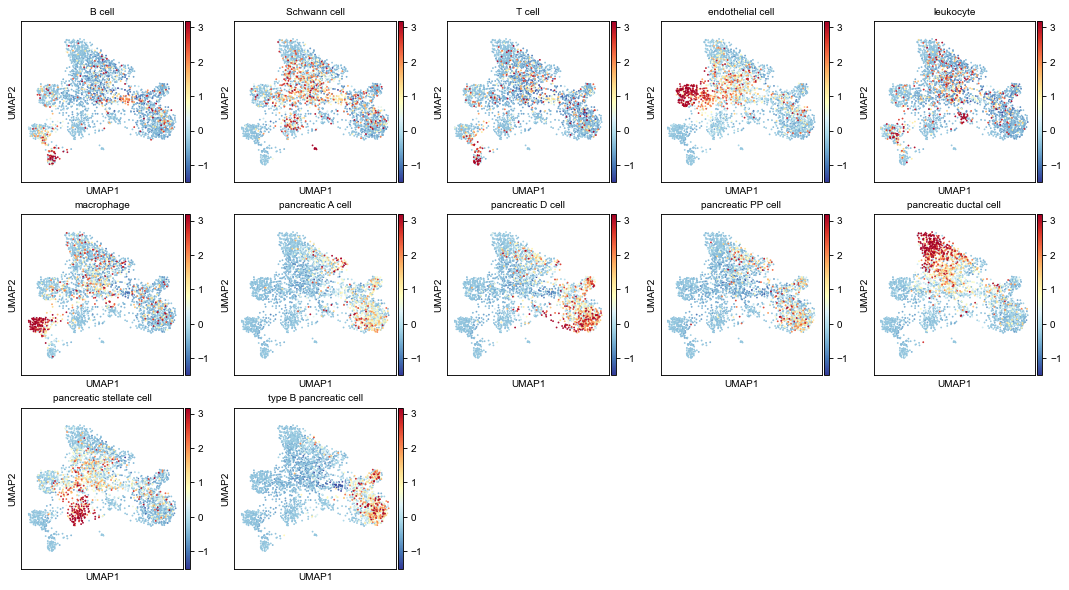

In [21]:
fig2

### 2.4 Abstracted graph

In [22]:
norm_ov = ['max', 'zs', None][1]
cut_ov = 0.  

groupby_var = 'module'
obs_labels1, obs_labels2 = adt.obs['celltype'][dpair.obs_ids1], \
                           adt.obs['celltype'][dpair.obs_ids2]
var_labels1, var_labels2 = gadt1.obs[groupby_var], gadt2.obs[groupby_var]

sp1, sp2 = 'human', 'mouse'
g = came.make_abstracted_graph(
    obs_labels1, obs_labels2,
    var_labels1, var_labels2,
    avg_expr1, avg_expr2,
    df_var_links,
    tags_obs=(f'{sp1} ', f'{sp2} '),
    tags_var=(f'{sp1} module ', f'{sp2} module '),
    cut_ov=cut_ov,
    norm_mtd_ov=norm_ov,
)


3332 2981
Edges with weights lower than 0 were cut out.
Edges with weights lower than 0 were cut out.
2801
2801 2801
---> aggregating edges...
unique labels of rows: ['5' '1' '2' '4' '6' '0' '9' '3' '7' '8' '10']
unique labels of columns: ['6' '2' '0' '7' '8' '9' '3' '5' '1' '4' '10']
grouping elements (edges)
shape of the one-hot-labels: (3332, 11) (2981, 11)
Re-order the rows
Re-order the columns
Re-order the columns
Re-order the columns
2801
2801 2801
---> aggregating edges...
unique labels of rows: ['5' '1' '2' '4' '6' '0' '9' '3' '7' '8' '10']
unique labels of columns: ['6' '2' '0' '7' '8' '9' '3' '5' '1' '4' '10']
grouping elements (edges)
shape of the one-hot-labels: (3332, 11) (2981, 11)


[13, 11, 11, 12]
figure has been saved into:
	_temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\figs\abstracted_graph-module-cut0.0-zs.pdf


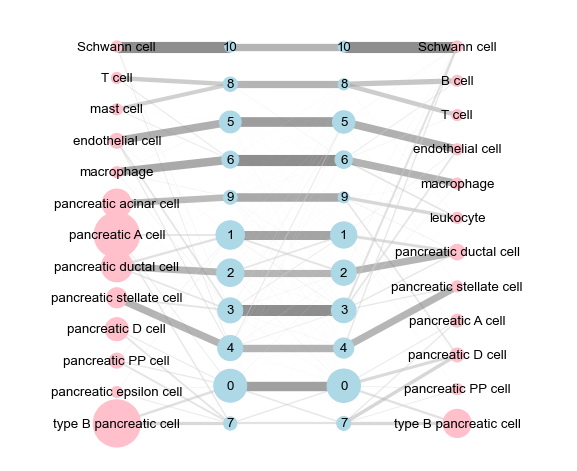

In [23]:
''' visualization '''
fp_abs = figdir / f'abstracted_graph-{groupby_var}-cut{cut_ov}-{norm_ov}.pdf'
ax = pl.plot_multipartite_graph(
    g, edge_scale=10,
    figsize=(9, 7.5), alpha=0.5, fp=fp_abs)  # nodelist=nodelist,

ax.figure

In [24]:
# save abstracted-graph object
came.save_pickle(g, resdir / 'abs_graph.pickle')

object saved into:
	 _temp\('Baron_human', 'Baron_mouse')-(12-16 18.36.34)\abs_graph.pickle
